In [ ]:
!apt-get update
!apt-get install -y ffmpeg
!pip install av

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:6 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:7 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:9 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [3,295 kB]
Get:10 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,553 kB]
Get:12 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:13 http://security.ubuntu.com/ubuntu jammy-security/ma

In [ ]:
import os
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from torchvision.io import read_video
from torchvision.models import resnet50
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
import matplotlib.pyplot as plt

!pip install opendatasets --quiet
import opendatasets as od

DATA_DIR = "/content/what-on-the-video"

if not os.path.isdir(DATA_DIR):
    od.download("https://www.kaggle.com/competitions/what-on-the-video")

print("Список файлов в корне датасета:", os.listdir(DATA_DIR))
print("Количество train видео:", len(os.listdir(os.path.join(DATA_DIR, "train"))))
print("Количество test видео:", len(os.listdir(os.path.join(DATA_DIR, "test"))))

train_csv_path = os.path.join(DATA_DIR, "train.csv")
train_df = pd.read_csv(train_csv_path)
train_df.head()

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: crimsondev
Your Kaggle Key: ··········


100%|██████████| 690M/690M [00:04<00:00, 166MB/s]



Extracting archive ./what-on-the-video/what-on-the-video.zip to ./what-on-the-video
Список файлов в корне датасета: ['sample_submit.csv', 'train.csv', 'test', 'train']
Количество train видео: 428
Количество test видео: 435


,path,labels
0,port_before_sunrise_preview.mp4,sunset
1,Louisiana speeding boat on Mississippi River_p...,cloud
2,170509A_Vietnam_03_preview.mp4,water
3,Croatia water on rocks at high tide pan_previe...,water
4,Arizona zoom on sunset mountain_preview.mp4,sunset


In [ ]:
train_df['labels'].value_counts()

,count
labels,
water,68
cloud,41
car,33
food,30
sunset,29
flower,29
animal,21
dance,17
"cloud, water",11


In [ ]:
all_labels = train_df["labels"].str.split(". ").explode()
unique_classes = all_labels.unique().tolist()

for cls in unique_classes:
    train_df[cls] = train_df["labels"].str.contains(rf"\b{cls}\b").astype(int)

train_df = train_df.drop(columns=["labels"])
train_df["path"] = train_df["path"].str.replace("_preview.mp4", "").str.strip()

train_df.head()

,path,sunset,cloud,water,food,flower,car,animal,dance,fire
0,port_before_sunrise,1,0,0,0,0,0,0,0,0
1,Louisiana speeding boat on Mississippi River,0,1,0,0,0,0,0,0,0
2,170509A_Vietnam_03,0,0,1,0,0,0,0,0,0
3,Croatia water on rocks at high tide pan,0,0,1,0,0,0,0,0,0
4,Arizona zoom on sunset mountain,1,0,0,0,0,0,0,0,0


In [ ]:
from sklearn.model_selection import train_test_split

train_rows, val_rows = train_test_split(
    train_df,
    test_size=0.2,
    random_state=42,
)

train_rows = train_rows.reset_index(drop=True)
val_rows   = val_rows.reset_index(drop=True)

print("Размеры:", train_rows.shape, val_rows.shape)

class VideoDataset(Dataset):
    def __init__(self, df, data_dir, classes, frames_per_clip=16, fps=5, transform=None, mode='train'):
        self.df = df
        self.data_dir = data_dir
        self.classes = classes
        self.frames_per_clip = frames_per_clip
        self.fps = fps
        self.transform = transform
        self.mode = mode

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.loc[idx]
        video_id = row["path"]

        video_path = os.path.join(self.data_dir, video_id + "_preview.mp4")
        video, _, info = read_video(video_path, pts_unit="sec")

        total_frames = video.shape[0]
        if total_frames >= self.frames_per_clip:
            indices = np.linspace(0, total_frames - 1, self.frames_per_clip).astype(int)
            clip = video[indices]
        else:
            last_frame = video[-1]
            indices = list(range(total_frames))
            n_extra = self.frames_per_clip - total_frames
            indices = indices + [total_frames - 1] * n_extra
            clip = video[indices]

        clip = clip.permute(0, 3, 1, 2)  # (T, C, H, W)
        if self.transform is not None:
            frames = []
            for t in range(clip.shape[0]):
                frame = clip[t].float() / 255.0
                frame = self.transform(frame)
                frames.append(frame)
            clip = torch.stack(frames, dim=0)
        else:
            clip = clip.float() / 255.0

        if self.mode == 'train':
          labels = torch.tensor(row[self.classes].values.astype(np.float32), dtype=torch.float32)
          return clip, labels
        else:
          return video_path, clip

train_transform = T.Compose([
    T.Resize((224, 224)),
])

val_transform = T.Compose([
    T.Resize((224, 224)),
])

batch_size = 8
train_dataset = VideoDataset(
    df=train_rows,
    data_dir='what-on-the-video/train',
    classes=unique_classes,
    frames_per_clip=16,
    fps=5,
    transform=train_transform
)

val_dataset = VideoDataset(
    df=val_rows,
    data_dir='what-on-the-video/train',
    classes=unique_classes,
    frames_per_clip=16,
    fps=5,
    transform=val_transform
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

Размеры: (232, 10) (58, 10)


In [ ]:
!ls what-on-the-video/test

 000464896-guatemala-antigua-church-festi_preview.mp4
 000691821-mexico-puerto-vallarta-ocean_preview.mp4
 000692230-panama-canal-clouds-over-gatun_preview.mp4
 000745494-florida-anhinga-dead-tree_preview.mp4
 000764644-sunset-and-boat_preview.mp4
 000939318-cincinnati-bridge-evening-cars_preview.mp4
 000939595-ecuador-weavings-otovalo-marke_preview.mp4
 000984040-steeple-church-kona-hawaii_preview.mp4
 000984827-honolulu-ala-moana-late-evenin_preview.mp4
 000984905-honolulu-skyline-clouds_preview.mp4
 000984908-honolulu-skyline-above_preview.mp4
 000985481-hydrangeas-and-gazebo-maui_preview.mp4
 000985854-upcountry-view-island-maui_preview.mp4
 000987148-waikiki-street-scene-and-build_preview.mp4
 005495163-white-flower_preview.mp4
 008608165-andalusia-salobrena-vies_preview.mp4
 010723413-massachusetts-salisbury-beach-_preview.mp4
 010896838-granada-isabel-columbus-statue_preview.mp4
 011001413-spain-stork-and-church-2_preview.mp4
 011004318-spain-storks-nest_preview.mp4
 011004667-s

In [ ]:
!ls what-on-the-video/train

 000690437-arizona-sedona-statue-cowboy-a_preview.mp4
 000691986-nemea-valley-vineyards_preview.mp4
 000692710-sunset-kathisma-beach_preview.mp4
 000693013-view-toward-skyscrapers_preview.mp4
 000763544-florida-boat-bay_preview.mp4
 000937113-edge-sea-kilauea-lava-flow_preview.mp4
 000939521-ecuador-crater-lake-view_preview.mp4
 000984125-marina-kona-coast-hawaii_preview.mp4
 000984652-hawaii-waiale-waterfall-view_preview.mp4
 000984824-honolulu-late-evening-ala-moan_preview.mp4
 000985273-lake-michigan-upper-peninsula_preview.mp4
 000985570-maui-lahaina-street-scene_preview.mp4
 000985632-lanai-waves-and-cloud_preview.mp4
 000985859-maui-view-haleakala-4_preview.mp4
 002197756-bonaire-bicycle-kralendiji_preview.mp4
 002200816-st-thomas-runway-mov_preview.mp4
 005501044-poinciana-flowers-wind_preview.mp4
 010713166-saba-sunset-clouds_preview.mp4
 010713170-saba-sunset_preview.mp4
 010894013-spain-castile-valle-de-iruelas_preview.mp4
 010918338-spain-merida-aqueduct-miracles_preview.mp4

In [ ]:
# Самописная сеть
class SkyNet(nn.Module):
    def __init__(self, num_classes=9, input_size=(3, 224, 224)):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.AvgPool2d(2, 2)
        self.dropout1 = nn.Dropout2d(p=0.2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.AvgPool2d(2, 2)
        self.dropout2 = nn.Dropout2d(p=0.2)

        with torch.no_grad():
            dummy = torch.zeros(1, *input_size)
            dummy = self.pool1(F.relu(self.bn1(self.conv1(dummy))))
            dummy = self.pool2(F.relu(self.bn2(self.conv2(dummy))))
            n_size = dummy.numel()

        self.fc1 = nn.Linear(n_size, 128)
        self.fc2 = nn.Linear(128, num_classes)

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        B, T, C, H, W = x.shape
        x = x.view(B * T, C, H, W)

        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.dropout1(x)

        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.dropout2(x)

        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.sigmoid(x)

        x = x.view(B, T, -1)
        out = x.mean(dim=1)
        return out

In [ ]:
# Модель на основе ResNet50
class ResNet50Classifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.backbone = resnet50(pretrained=True)
        self.backbone.fc = nn.Linear(self.backbone.fc.in_features, num_classes)

    def forward(self, clip):
        batch_size, T, C, H, W = clip.shape
        clip = clip.view(batch_size * T, C, H, W)
        features = self.backbone(clip)
        features = features.view(batch_size, T, -1)
        out = features.mean(dim=1)
        return out

In [ ]:
class ResNet50RNNClassifier(nn.Module):
    def __init__(self, num_classes, hidden_size=256, num_layers=1, bidirectional=False):
        super().__init__()
        self.backbone = resnet50(pretrained=True)
        self.backbone.fc = nn.Identity()

        self.feature_dim = self.backbone.fc.in_features if hasattr(self.backbone.fc, 'in_features') else 2048

        self.rnn = nn.LSTM(
            input_size=self.feature_dim,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional
        )

        rnn_output_size = hidden_size * (2 if bidirectional else 1)
        self.classifier = nn.Linear(rnn_output_size, num_classes)

    def forward(self, clip):
        batch_size, T, C, H, W = clip.shape
        clip = clip.view(batch_size * T, C, H, W)

        with torch.no_grad():
            features = self.backbone(clip)

        features = features.view(batch_size, T, -1)

        rnn_out, _ = self.rnn(features)

        out = rnn_out[:, -1, :]

        return self.classifier(out)

In [ ]:
num_classes = len(unique_classes)
num_classes

9

In [ ]:
import av

def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    all_preds = []
    all_targets = []

    for clips, targets in tqdm(loader, desc="Train batches"):
        clips = clips.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        outputs = model(clips)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * clips.size(0)
        all_preds.append(outputs.detach().cpu().numpy())
        all_targets.append(targets.detach().cpu().numpy())

    epoch_loss = running_loss / len(loader.dataset)
    preds = np.concatenate(all_preds, axis=0)
    trues = np.concatenate(all_targets, axis=0)
    try:
        epoch_auc = roc_auc_score(trues, preds, multi_class='ovr', average='macro')
    except:
        epoch_auc = float("nan")
    return epoch_loss, epoch_auc

def validate_one_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for clips, targets in tqdm(loader, desc="Val batches"):
            clips = clips.to(device)
            targets = targets.to(device)

            outputs = model(clips)
            loss = criterion(outputs, targets)
            running_loss += loss.item() * clips.size(0)

            all_preds.append(outputs.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    val_loss = running_loss / len(loader.dataset)
    preds = np.concatenate(all_preds, axis=0)
    trues = np.concatenate(all_targets, axis=0)
    try:
        val_auc = roc_auc_score(trues, preds, multi_class='ovr', average='macro')
    except:
        val_auc = float("nan")
    return val_loss, val_auc

def train_loop(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    num_epochs=5,
    save_path="best_model.pth"
):
    best_auc = 0.0
    history = {
        "train_loss": [],
        "train_auc": [],
        "val_loss": [],
        "val_auc": []
    }

    for epoch in range(1, num_epochs + 1):
        print(f"\n=== Epoch {epoch}/{num_epochs} ===")

        train_loss, train_auc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_auc     = validate_one_epoch(model, val_loader, criterion, device)

        print(f"  Train loss: {train_loss:.4f}, Train AUC: {train_auc:.4f}")
        print(f"  Val   loss: {val_loss:.4f}, Val   AUC: {val_auc:.4f}")

        history["train_loss"].append(train_loss)
        history["train_auc"].append(train_auc)
        history["val_loss"].append(val_loss)
        history["val_auc"].append(val_auc)
        print(val_auc, best_auc)
        if val_auc > best_auc:
            best_auc = val_auc
            torch.save(model.state_dict(), save_path)
            print(f"Сохраняем модель, val_auc = {val_auc:.4f}")

    print(f'Best AUC: {best_auc}')
    history['best_auc'] = best_auc

    return history

# Эксперименты

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
def plot_experiment(history):
  plt.figure(figsize=(8, 4))
  plt.plot(history["train_loss"], label="Train Loss")
  plt.plot(history["val_loss"],   label="Val Loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend()
  plt.title("Loss over epochs")
  plt.show()

  plt.figure(figsize=(8, 4))
  plt.plot(history["train_auc"], label="Train AUC")
  plt.plot(history["val_auc"],   label="Val AUC")
  plt.xlabel("Epoch")
  plt.ylabel("ROC AUC")
  plt.legend()
  plt.title("ROC AUC over epochs")
  plt.show()

In [ ]:
# 4 эксперимента:
# SkyNet и BCEWithLogitsLoss
# SkyNet и MSE
# ResNet50 и BCEWithLogitsLoss
# ResNet50 и MSE

import warnings
warnings.filterwarnings('ignore')

num_epochs = 10
device = torch.device('cuda')

cnt = 1
best_auc = (-1, -1)

experiments = [
    (SkyNet(num_classes).to(device), nn.BCEWithLogitsLoss()),
    (SkyNet(num_classes).to(device), nn.MSELoss()),
    (ResNet50Classifier(num_classes).to(device), nn.BCEWithLogitsLoss()),
    (ResNet50Classifier(num_classes).to(device), nn.MSELoss()),
]

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 92.0MB/s]


In [ ]:
def experiment(num):
    global best_auc
    model, criterion = experiments[num]

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    save_path = f"best_save_ex{num}.pth"

    history = train_loop(
      model=model,
      train_loader=train_loader,
      val_loader=val_loader,
      criterion=criterion,
      optimizer=optimizer,
      device=device,
      num_epochs=num_epochs,
      save_path=save_path
    )

    plot_experiment(history)

    if history['best_auc'] > best_auc[0]:
      best_auc = history['best_auc'], num


=== Epoch 1/10 ===


Val batches: 100%|██████████| 8/8 [00:18<00:00,  2.37s/it]


  Train loss: 0.7013, Train AUC: 0.4843
  Val   loss: 0.6931, Val   AUC: 0.4797
0.4796995235078651 0.0
Сохраняем модель, val_auc = 0.4797

=== Epoch 2/10 ===


Val batches: 100%|██████████| 8/8 [00:17<00:00,  2.25s/it]


  Train loss: 0.6931, Train AUC: 0.4776
  Val   loss: 0.6931, Val   AUC: 0.4482
0.4481613866842268 0.4796995235078651

=== Epoch 3/10 ===


Val batches: 100%|██████████| 8/8 [00:18<00:00,  2.34s/it]


  Train loss: 0.6931, Train AUC: 0.4841
  Val   loss: 0.6931, Val   AUC: 0.4472
0.4472001624198745 0.4796995235078651

=== Epoch 4/10 ===


Val batches: 100%|██████████| 8/8 [00:18<00:00,  2.35s/it]


  Train loss: 0.6931, Train AUC: 0.4694
  Val   loss: 0.6931, Val   AUC: 0.4497
0.44970822476284245 0.4796995235078651

=== Epoch 5/10 ===


Val batches: 100%|██████████| 8/8 [00:18<00:00,  2.29s/it]


  Train loss: 0.6931, Train AUC: 0.4560
  Val   loss: 0.6931, Val   AUC: 0.4476
0.4476426985699578 0.4796995235078651

=== Epoch 6/10 ===


Val batches: 100%|██████████| 8/8 [00:18<00:00,  2.37s/it]


  Train loss: 0.6931, Train AUC: 0.4793
  Val   loss: 0.6931, Val   AUC: 0.4481
0.44810521386737867 0.4796995235078651

=== Epoch 7/10 ===


Val batches: 100%|██████████| 8/8 [00:18<00:00,  2.31s/it]


  Train loss: 0.6931, Train AUC: 0.4772
  Val   loss: 0.6931, Val   AUC: 0.4458
0.4458421537269601 0.4796995235078651

=== Epoch 8/10 ===


Val batches: 100%|██████████| 8/8 [00:18<00:00,  2.37s/it]


  Train loss: 0.6931, Train AUC: 0.4525
  Val   loss: 0.6931, Val   AUC: 0.4425
0.4425371669872663 0.4796995235078651

=== Epoch 9/10 ===


Val batches: 100%|██████████| 8/8 [00:18<00:00,  2.29s/it]


  Train loss: 0.6931, Train AUC: 0.4807
  Val   loss: 0.6931, Val   AUC: 0.4474
0.44739277815494305 0.4796995235078651

=== Epoch 10/10 ===


Val batches: 100%|██████████| 8/8 [00:18<00:00,  2.37s/it]

  Train loss: 0.6931, Train AUC: 0.4757
  Val   loss: 0.6931, Val   AUC: 0.4478
0.4478433461055109 0.4796995235078651
Best AUC: 0.4796995235078651


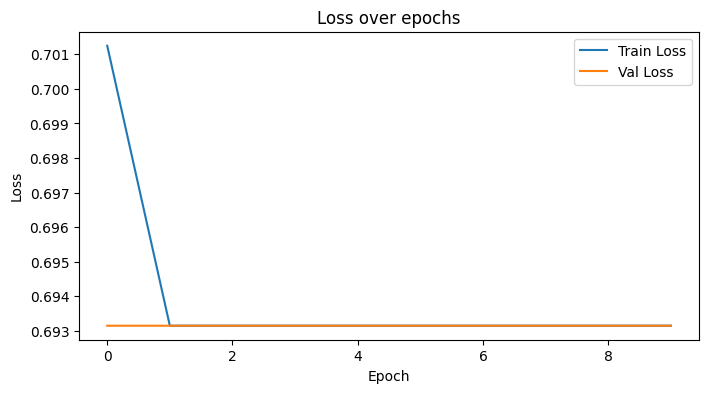

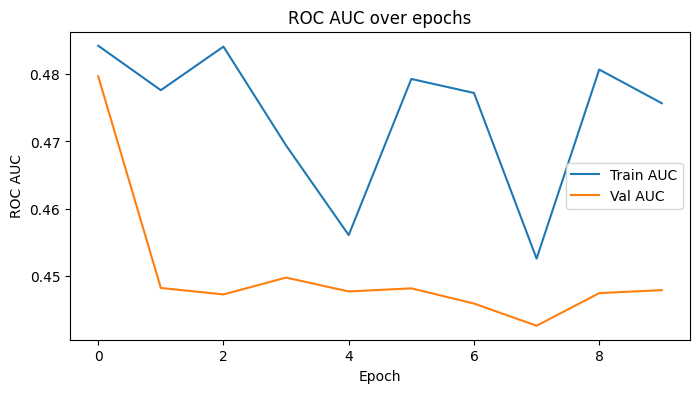

In [ ]:
experiment(0)


=== Epoch 1/10 ===


Val batches: 100%|██████████| 8/8 [00:18<00:00,  2.28s/it]


  Train loss: 0.1689, Train AUC: 0.5044
  Val   loss: 0.1724, Val   AUC: 0.5249
0.5249355209596023 0.0
Сохраняем модель, val_auc = 0.5249

=== Epoch 2/10 ===


Val batches: 100%|██████████| 8/8 [00:18<00:00,  2.32s/it]


  Train loss: 0.1647, Train AUC: 0.5207
  Val   loss: 0.1724, Val   AUC: 0.5022
0.5021708699278213 0.5249355209596023

=== Epoch 3/10 ===


Val batches: 100%|██████████| 8/8 [00:18<00:00,  2.34s/it]


  Train loss: 0.1554, Train AUC: 0.5500
  Val   loss: 0.1087, Val   AUC: 0.5360
0.5359874455145061 0.5249355209596023
Сохраняем модель, val_auc = 0.5360

=== Epoch 4/10 ===


Val batches: 100%|██████████| 8/8 [00:18<00:00,  2.30s/it]


  Train loss: 0.1145, Train AUC: 0.5472
  Val   loss: 0.1127, Val   AUC: 0.5310
0.531021842505209 0.5359874455145061

=== Epoch 5/10 ===


Val batches: 100%|██████████| 8/8 [00:18<00:00,  2.37s/it]


  Train loss: 0.1114, Train AUC: 0.5385
  Val   loss: 0.1215, Val   AUC: 0.5195
0.5194715178069199 0.5359874455145061

=== Epoch 6/10 ===


Val batches: 100%|██████████| 8/8 [00:18<00:00,  2.30s/it]


  Train loss: 0.1098, Train AUC: 0.5350
  Val   loss: 0.1139, Val   AUC: 0.5247
0.524679330149787 0.5359874455145061

=== Epoch 7/10 ===


Val batches: 100%|██████████| 8/8 [00:18<00:00,  2.35s/it]


  Train loss: 0.1125, Train AUC: 0.5313
  Val   loss: 0.1135, Val   AUC: 0.5266
0.5265742769863923 0.5359874455145061

=== Epoch 8/10 ===


Val batches: 100%|██████████| 8/8 [00:18<00:00,  2.35s/it]


  Train loss: 0.1096, Train AUC: 0.5552
  Val   loss: 0.1154, Val   AUC: 0.5188
0.5188379091668565 0.5359874455145061

=== Epoch 9/10 ===


Val batches: 100%|██████████| 8/8 [00:18<00:00,  2.28s/it]


  Train loss: 0.1053, Train AUC: 0.5452
  Val   loss: 0.1164, Val   AUC: 0.5014
0.5013864956901204 0.5359874455145061

=== Epoch 10/10 ===


Val batches: 100%|██████████| 8/8 [00:18<00:00,  2.33s/it]

  Train loss: 0.1057, Train AUC: 0.5263
  Val   loss: 0.1168, Val   AUC: 0.4981
0.4981256518868238 0.5359874455145061
Best AUC: 0.5359874455145061


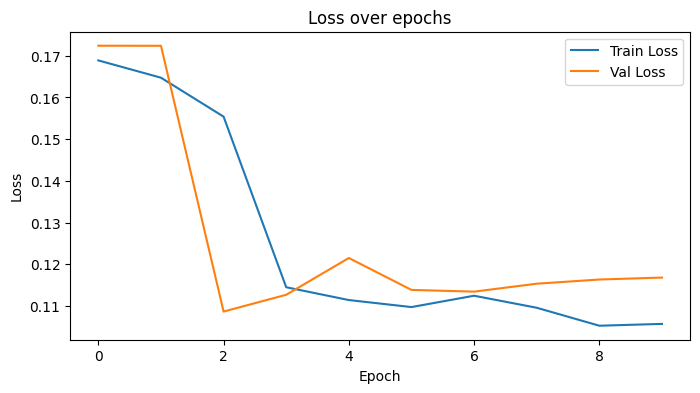

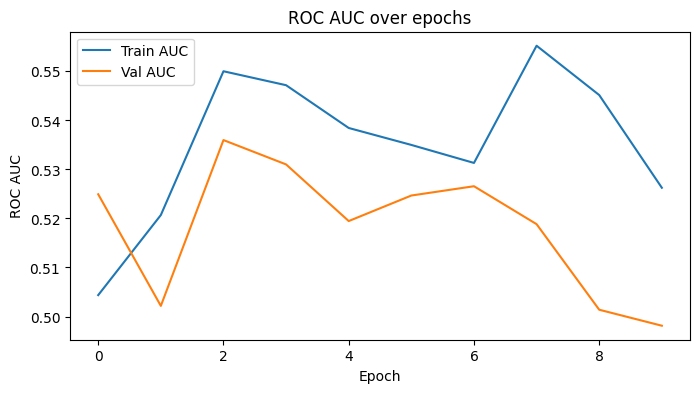

In [ ]:
experiment(1)

In [ ]:
experiment(2)


=== Epoch 1/10 ===


Val batches: 100%|██████████| 8/8 [00:20<00:00,  2.57s/it]


  Train loss: 0.3731, Train AUC: 0.7422
  Val   loss: 0.1709, Val   AUC: 0.9685
0.9684674497410346 0.0
Сохраняем модель, val_auc = 0.9685

=== Epoch 2/10 ===


Val batches: 100%|██████████| 8/8 [00:20<00:00,  2.60s/it]


  Train loss: 0.1714, Train AUC: 0.9614
  Val   loss: 0.0529, Val   AUC: 0.9989
0.99894943019943 0.9684674497410346
Сохраняем модель, val_auc = 0.9989

=== Epoch 3/10 ===


Val batches: 100%|██████████| 8/8 [00:20<00:00,  2.53s/it]


  Train loss: 0.1239, Train AUC: 0.9825
  Val   loss: 0.0489, Val   AUC: 0.9977
0.9976851851851851 0.99894943019943

=== Epoch 4/10 ===


Val batches: 100%|██████████| 8/8 [00:20<00:00,  2.56s/it]


  Train loss: 0.0989, Train AUC: 0.9837
  Val   loss: 0.0207, Val   AUC: 1.0000
1.0 0.99894943019943
Сохраняем модель, val_auc = 1.0000

=== Epoch 5/10 ===


Val batches: 100%|██████████| 8/8 [00:20<00:00,  2.53s/it]


  Train loss: 0.0746, Train AUC: 0.9941
  Val   loss: 0.0120, Val   AUC: 1.0000
1.0 1.0

=== Epoch 6/10 ===


Train batches:  76%|███████▌  | 28/37 [01:46<00:34,  3.82s/it]


=== Epoch 1/10 ===


Val batches: 100%|██████████| 8/8 [00:20<00:00,  2.52s/it]


  Train loss: 0.1099, Train AUC: 0.7341
  Val   loss: 0.1177, Val   AUC: 0.7870
0.7870175114800239 0.0
Сохраняем модель, val_auc = 0.7870

=== Epoch 2/10 ===


Val batches: 100%|██████████| 8/8 [00:20<00:00,  2.53s/it]


  Train loss: 0.0560, Train AUC: 0.9627
  Val   loss: 0.0916, Val   AUC: 0.8876
0.8875910387380099 0.7870175114800239
Сохраняем модель, val_auc = 0.8876

=== Epoch 3/10 ===


Val batches: 100%|██████████| 8/8 [00:19<00:00,  2.38s/it]


  Train loss: 0.0369, Train AUC: 0.9938
  Val   loss: 0.0712, Val   AUC: 0.8868
0.8867721472686716 0.8875910387380099

=== Epoch 4/10 ===


Val batches: 100%|██████████| 8/8 [00:20<00:00,  2.57s/it]


  Train loss: 0.0276, Train AUC: 0.9979
  Val   loss: 0.0752, Val   AUC: 0.9094
0.9094217282313112 0.8875910387380099
Сохраняем модель, val_auc = 0.9094

=== Epoch 5/10 ===


Val batches: 100%|██████████| 8/8 [00:20<00:00,  2.55s/it]


  Train loss: 0.0249, Train AUC: 0.9996
  Val   loss: 0.0727, Val   AUC: 0.9072
0.9071542026420377 0.9094217282313112

=== Epoch 6/10 ===


Val batches: 100%|██████████| 8/8 [00:19<00:00,  2.45s/it]


  Train loss: 0.0259, Train AUC: 0.9987
  Val   loss: 0.0691, Val   AUC: 0.9042
0.9042099989642194 0.9094217282313112

=== Epoch 7/10 ===


Val batches: 100%|██████████| 8/8 [00:20<00:00,  2.53s/it]


  Train loss: 0.0200, Train AUC: 0.9999
  Val   loss: 0.0695, Val   AUC: 0.9265
0.9265431519912651 0.9094217282313112
Сохраняем модель, val_auc = 0.9265

=== Epoch 8/10 ===


Val batches: 100%|██████████| 8/8 [00:19<00:00,  2.46s/it]


  Train loss: 0.0192, Train AUC: 0.9999
  Val   loss: 0.0716, Val   AUC: 0.8901
0.8901423538762169 0.9265431519912651

=== Epoch 9/10 ===


Val batches: 100%|██████████| 8/8 [00:25<00:00,  3.17s/it]


  Train loss: 0.0192, Train AUC: 1.0000
  Val   loss: 0.0663, Val   AUC: 0.9285
0.9284952006414271 0.9265431519912651
Сохраняем модель, val_auc = 0.9285

=== Epoch 10/10 ===


Val batches: 100%|██████████| 8/8 [00:20<00:00,  2.53s/it]


  Train loss: 0.0197, Train AUC: 0.9996
  Val   loss: 0.0597, Val   AUC: 0.9433
0.9432613447000241 0.9284952006414271
Сохраняем модель, val_auc = 0.9433
Best AUC: 0.9432613447000241


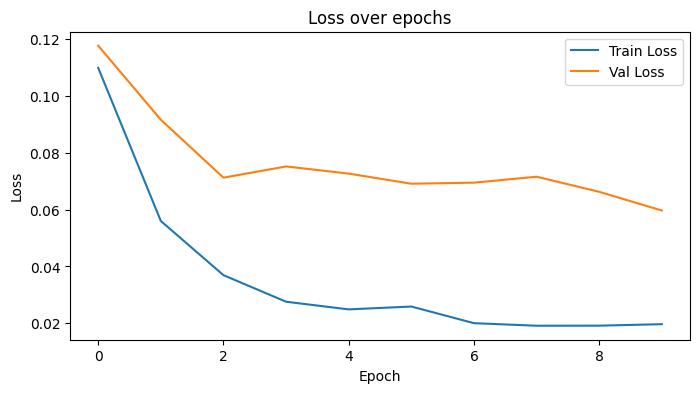

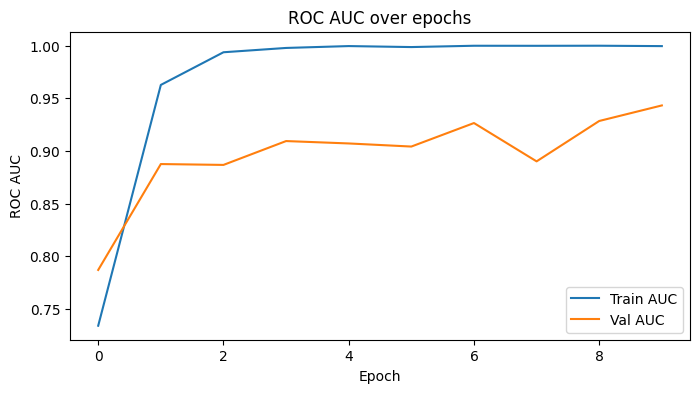

In [ ]:
experiment(3)

In [ ]:
model, criterion = ResNet50RNNClassifier(num_classes, num_layers=3).to(device), nn.BCEWithLogitsLoss()
model.load_state_dict(torch.load('best_save_ex_recc.pth'))
optimizer = torch.optim.Adam(model.parameters(), lr=1e-6)
save_path = f"best_save_ex_recc.pth"

num_epochs = 20

history = train_loop(
  model=model,
  train_loader=train_loader,
  val_loader=val_loader,
  criterion=criterion,
  optimizer=optimizer,
  device=device,
  num_epochs=num_epochs,
  save_path=save_path
)

print('Best AUC:', history['best_auc'])
plot_experiment(history)


=== Epoch 1/20 ===


Val batches: 100%|██████████| 8/8 [00:19<00:00,  2.47s/it]


  Train loss: 0.6995, Train AUC: 0.5410
  Val   loss: 0.6987, Val   AUC: 0.5417
0.5417435223939693 0.0
Сохраняем модель, val_auc = 0.5417

=== Epoch 2/20 ===


Val batches: 100%|██████████| 8/8 [00:20<00:00,  2.52s/it]


  Train loss: 0.6980, Train AUC: 0.5161
  Val   loss: 0.6972, Val   AUC: 0.5492
0.5492235127041484 0.5417435223939693
Сохраняем модель, val_auc = 0.5492

=== Epoch 3/20 ===


Val batches: 100%|██████████| 8/8 [00:20<00:00,  2.53s/it]


  Train loss: 0.6965, Train AUC: 0.5593
  Val   loss: 0.6959, Val   AUC: 0.5558
0.5557763135481605 0.5492235127041484
Сохраняем модель, val_auc = 0.5558

=== Epoch 4/20 ===


Val batches: 100%|██████████| 8/8 [00:19<00:00,  2.50s/it]


  Train loss: 0.6949, Train AUC: 0.5238
  Val   loss: 0.6944, Val   AUC: 0.5434
0.5434102981409337 0.5557763135481605

=== Epoch 5/20 ===


Val batches: 100%|██████████| 8/8 [00:19<00:00,  2.49s/it]


  Train loss: 0.6933, Train AUC: 0.5333
  Val   loss: 0.6929, Val   AUC: 0.5449
0.5449179288106796 0.5557763135481605

=== Epoch 6/20 ===


Val batches: 100%|██████████| 8/8 [00:20<00:00,  2.53s/it]


  Train loss: 0.6916, Train AUC: 0.5519
  Val   loss: 0.6912, Val   AUC: 0.5519
0.5518568227902886 0.5557763135481605

=== Epoch 7/20 ===


Val batches: 100%|██████████| 8/8 [00:20<00:00,  2.52s/it]


  Train loss: 0.6898, Train AUC: 0.5426
  Val   loss: 0.6897, Val   AUC: 0.5465
0.5464871047430631 0.5557763135481605

=== Epoch 8/20 ===


Train batches:  93%|█████████▎| 27/29 [01:19<00:05,  2.96s/it]


KeyboardInterrupt: 


=== Epoch 1/10 ===


Val batches: 100%|██████████| 8/8 [00:19<00:00,  2.49s/it]


  Train loss: 0.3302, Train AUC: 0.7629
  Val   loss: 0.3289, Val   AUC: 0.7373
0.73730706423482 0.0
Сохраняем модель, val_auc = 0.7373

=== Epoch 2/10 ===


Val batches: 100%|██████████| 8/8 [00:19<00:00,  2.45s/it]


  Train loss: 0.3310, Train AUC: 0.7500
  Val   loss: 0.3288, Val   AUC: 0.7399
0.7398664798366884 0.73730706423482
Сохраняем модель, val_auc = 0.7399

=== Epoch 3/10 ===


Val batches: 100%|██████████| 8/8 [00:20<00:00,  2.50s/it]


  Train loss: 0.3306, Train AUC: 0.7407
  Val   loss: 0.3290, Val   AUC: 0.7337
0.7337295306572864 0.7398664798366884

=== Epoch 4/10 ===


Val batches: 100%|██████████| 8/8 [00:19<00:00,  2.46s/it]


  Train loss: 0.3303, Train AUC: 0.7398
  Val   loss: 0.3291, Val   AUC: 0.7370
0.7370448727226284 0.7398664798366884

=== Epoch 5/10 ===


Val batches: 100%|██████████| 8/8 [00:20<00:00,  2.51s/it]


  Train loss: 0.3301, Train AUC: 0.7542
  Val   loss: 0.3292, Val   AUC: 0.7329
0.7329122923400481 0.7398664798366884

=== Epoch 6/10 ===


Val batches: 100%|██████████| 8/8 [00:20<00:00,  2.50s/it]


  Train loss: 0.3302, Train AUC: 0.7352
  Val   loss: 0.3293, Val   AUC: 0.7351
0.7350653087855172 0.7398664798366884

=== Epoch 7/10 ===


Val batches: 100%|██████████| 8/8 [00:19<00:00,  2.43s/it]


  Train loss: 0.3307, Train AUC: 0.7523
  Val   loss: 0.3291, Val   AUC: 0.7371
0.7370976283178368 0.7398664798366884

=== Epoch 8/10 ===


Val batches: 100%|██████████| 8/8 [00:20<00:00,  2.51s/it]


  Train loss: 0.3308, Train AUC: 0.7460
  Val   loss: 0.3289, Val   AUC: 0.7345
0.7345363142595019 0.7398664798366884

=== Epoch 9/10 ===


Val batches: 100%|██████████| 8/8 [00:19<00:00,  2.43s/it]


  Train loss: 0.3299, Train AUC: 0.7365
  Val   loss: 0.3292, Val   AUC: 0.7342
0.734204394717056 0.7398664798366884

=== Epoch 10/10 ===


Val batches: 100%|██████████| 8/8 [00:20<00:00,  2.51s/it]

  Train loss: 0.3309, Train AUC: 0.7386
  Val   loss: 0.3289, Val   AUC: 0.7374
0.7373939061141147 0.7398664798366884
Best AUC: 0.7398664798366884
Best AUC: 0.7398664798366884


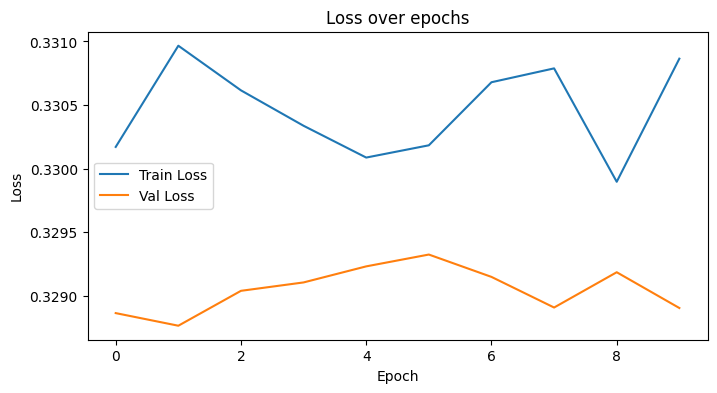

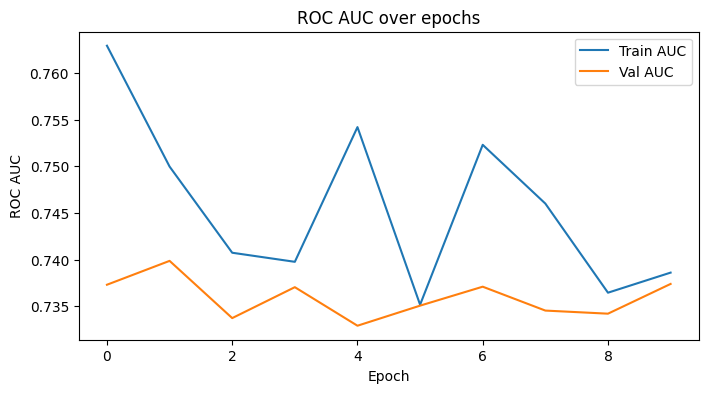

In [ ]:
history = train_loop(
  model=model,
  train_loader=train_loader,
  val_loader=val_loader,
  criterion=criterion,
  optimizer=optimizer,
  device=device,
  num_epochs=num_epochs,
  save_path=save_path
)

print('Best AUC:', history['best_auc'])
plot_experiment(history)

In [ ]:
print(f'Лучший AUC: {best_auc[0]:.4f}')

Лучший AUC: 0.9433


Генерация ответа

In [ ]:
import os
import pandas as pd

folder_path = "what-on-the-video/test"
video_extensions = {'.mp4', '.avi', '.mov', '.mkv', '.flv'}
video_files = []

for file in sorted(os.listdir(folder_path)):
    if os.path.splitext(file)[1].lower() in video_extensions:
        video_files.append(file.replace('_preview.mp4', ''))

test_df = pd.DataFrame(video_files, columns=["path"])

print(f"Найдено {len(video_files)} видео")

Найдено 435 видео


In [ ]:
test_df

,path
0,000464896-guatemala-antigua-church-festi
1,000691821-mexico-puerto-vallarta-ocean
2,000692230-panama-canal-clouds-over-gatun
3,000745494-florida-anhinga-dead-tree
4,000764644-sunset-and-boat
...,...
430,myrdalssandur_iceland_one
431,reed1
432,rifugio_becco
433,rover_and_rocks_medium


In [ ]:
test_dataset = VideoDataset(
    df=test_df,
    data_dir='/content/what-on-the-video/test',
    classes=unique_classes,
    frames_per_clip=16,
    fps=5,
    transform=val_transform,
    mode='test'
)

In [ ]:
unique_classes

['sunset',
 'cloud',
 'water',
 'food',
 'flower',
 'car',
 'animal',
 'dance',
 'fire']

In [ ]:
device = torch.device('cuda')
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
model = ResNet50RNNClassifier(num_classes, num_layers=3).to(device)
model.load_state_dict(torch.load('best_save_ex_recc.pth'))

<All keys matched successfully>

In [ ]:
model.eval()
answer = []

with torch.no_grad():
    for video_paths, clips in tqdm(test_loader, desc="Generating answer..."):
        clips = clips.to(device)

        outputs = nn.Sigmoid()(model(clips)) > 0.5
        outputs = [', '.join([unique_classes[i] for i in range(len(ans)) if ans[i] == 1])  for ans in outputs]
        outputs = ['water' if ans == '' else ans for ans in outputs]

        rows = [{'file_name': filename, 'label': label} for filename, label in zip(video_paths, outputs)]
        answer += rows

answer = pd.DataFrame(answer)
answer

Generating answer...: 100%|██████████| 55/55 [02:48<00:00,  3.06s/it]


,file_name,label
0,/content/what-on-the-video/test/000464896-guat...,water
1,/content/what-on-the-video/test/000691821-mexi...,water
2,/content/what-on-the-video/test/000692230-pana...,water
3,/content/what-on-the-video/test/000745494-flor...,water
4,/content/what-on-the-video/test/000764644-suns...,water
...,...,...
430,/content/what-on-the-video/test/myrdalssandur_...,water
431,/content/what-on-the-video/test/reed1_preview.mp4,water
432,/content/what-on-the-video/test/rifugio_becco_...,water
433,/content/what-on-the-video/test/rover_and_rock...,water


In [ ]:
answer.to_csv('my_submit.csv', index_label='index')